# 1. Introduction

**Hacktiv8 - Final Project**

**Batch RMT-038**

**Team Members**
- Julita G. Ariana, Data Scientist
- Niko A. Hakam, Data Scientist
- Nisrina Tsany S., Data Analyst
- Ryan Dionenatan, Data Engineer
- Verren Monica, Data Analyst



# 2. Background & Objectives

**Background**:

Industri logistik di Indonesia terus berkembang seiring dengan meningkatnya permintaan akan layanan pengiriman yang cepat, andal, dan terjangkau. Namun, tantangan besar masih ada, terutama terkait dengan keluhan pelanggan yang dapat berdampak pada reputasi dan keberlanjutan bisnis. Banyak ulasan negatif di platform seperti Google Maps memberikan wawasan langsung tentang masalah yang dihadapi oleh gudang pengiriman di berbagai wilayah. Dengan analisis yang tepat, data ulasan ini dapat digunakan untuk mengidentifikasi dan memahami akar penyebab masalah tersebut serta memberikan saran yang relevan bagi perusahaan.

**Objectives**:
- Membuat model dengan algoritma Latent Dirichlet Allocation (LDA) untuk mengelompokkan ulasan dari Google Maps ke dalam beberapa cluster.
- Menyajikan hasil analisis melalui visualisasi (pie chart, word cloud) untuk memberikan wawasan tentang kepuasan pelanggan, serta menyajikan saran lanjutan untuk meningkatkan kualitas layanan di seluruh wilayah operasional.


# 3. Import Libraries

In [1]:
# Import libraries
import pandas as pd
import asyncio
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import contractions
from googletrans import Translator
import json
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

from gensim.corpora import Dictionary

from gensim.models import LdaModel
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import pickle


import nest_asyncio
nest_asyncio.apply()

import nest_asyncio
nest_asyncio.apply()

import warnings
warnings.filterwarnings("ignore")

# 4. Initialization & Text Data Preparation

Bagian ini berfokus pada inisialisasi tools dan pustaka yang diperlukan untuk memproses data teks ulasan pelanggan dalam Bahasa Indonesia. Proses ini bertujuan untuk memastikan teks mentah dapat diproses lebih lanjut untuk proses modeling menggunakan LDA.

In [2]:
# Initialize Bahasa Indonesia stopwords
stpwds_id = stopwords.words('indonesian')

# Initialize Sastrawi stemmer for Bahasa Indonesia
factory = StemmerFactory()
stemmer_id = factory.create_stemmer()

- Untuk stpwds_id akan berisi daftar stopwords dalam Bahasa Indonesia dimana tujuannya untuk inisialisasi daftar stopword Bahasa Indonesia. Stopwords dihapus untuk meningkatkan efisiensi dan fokus pada kata yang lebih bermakna. Fungsi stopwords ini berasal dari NLTK (Natural Language Toolkit) yang menyediakan daftar stopwords untuk berbagai bahasa (dalam konteks ini digunakan bahasa indonesia). Contoh stopwords: ['yang', 'dan', 'di', 'ke', 'dengan', 'akan', 'dari', 'pada', 'untuk']

- stemmer_id berisi stemmer untuk digunakan dalam proses teks dalam Bahasa Indonesia dimana tujuannya untuk inisialisasi stemmer dengan pustaka Sastrawi. Stemmer disini untuk ubah kata berimbuhan jadi kata dasarnya. Contoh stemmer: ['Pengiriman' -> 'kirim']

Kemudian dilakukan inisialisasi objek Translator dari pustaka googletrans, yang digunakan untuk menerjemahkan teks antar bahasa secara otomatis. Hal ini dilakukan karena review yang diberikan oleh pelanggan menggunakan berbagai macam bahasa mulai dari Bahasa Indonesia, Bahasa Inggris, dan berbagai bahasa daerah di Indonesia.

In [3]:
# Initialize translator
translator = Translator()

Karena dalam teks review masih terdapat banyak teks informal atau gaul (slang), maka telah dibuat file json berisi pergantian dari teks slang ke kata formal agar teks lebih mudah dianalisis. Kemudian file tersebut di load untuk pemrosesan teks lebih lanjut.

In [4]:
# Load the slang dictionary
with open('slang_bank.json', 'r') as file:
    slang_dict = json.load(file)

# 5. Compile Datasets

Pada bagian ini dilakukan penggabungan seluruh dataset dari hasil web scraping yang telah dilakukan.

In [5]:
# # Combine the datasets
# # Define the folder path
# folder_path = './reviews'

# # Initialize an empty list to store dataframes
# dataframes = []

# # Iterate over all files in the folder
# for file_name in os.listdir(folder_path):
#     if file_name.endswith('.csv'):  # Check if the file is a CSV
#         file_path = os.path.join(folder_path, file_name)
#         # Read the CSV file into a dataframe
#         df = pd.read_csv(file_path)
#         # Optionally add a column to track the source file
#         df['Source'] = file_name
#         # Append the dataframe to the list
#         dataframes.append(df)

# # Combine all dataframes into a single dataframe
# combined_df = pd.concat(dataframes, ignore_index=True)

# # Save the combined dataframe to a CSV file
# output_path = 'compiled_reviews.csv'
# combined_df.to_csv(output_path, index=False)

# print(f"Combined dataframe saved to {output_path}")

# 6. Data Loading

In [6]:
# Load data
final_df = pd.read_csv('compiled_reviews.csv')

In [7]:
# Display data
final_df

,Rating,Reviews,Date,Company,Province,Source
0,5,"Located at the Padang Old City area, just arou...",9 months ago,JNE,Aceh,JNE_Aceh.csv
1,1,"Bad service given to customers, my own experie...",4 years ago,JNE,Aceh,JNE_Aceh.csv
2,5,"Nice Place, they're working on rebuild their o...",3 years ago,JNE,Aceh,JNE_Aceh.csv
3,5,Good delivery service for customers in this co...,2 years ago,JNE,Aceh,JNE_Aceh.csv
4,5,Good service,3 years ago,JNE,Aceh,JNE_Aceh.csv
...,...,...,...,...,...,...
27160,1,No review found,NaN,Sicepat,Sumatera Utara,Sicepat_Sumatera Utara.csv
27161,1,No review found,NaN,Sicepat,Sumatera Utara,Sicepat_Sumatera Utara.csv
27162,1,No review found,NaN,Sicepat,Sumatera Utara,Sicepat_Sumatera Utara.csv
27163,2,No review found,NaN,Sicepat,Sumatera Utara,Sicepat_Sumatera Utara.csv


In [8]:
# Remove rows with 'No review found'
final_df = final_df[final_df['Reviews'] != 'No review found']

In [9]:
# Display data shape
final_df.shape

(18090, 6)

# 7. Parse Date

Pada bagian ini dilakukan konversi format tanggal dari hasil scraping menjadi object tanggal yang dapat dioperasikan.

In [10]:
# Calculate the mode of the 'Date' column
mode_value = final_df['Date'].mode()[0]

# Fill NaN values in the 'Date' column with the mode
final_df['Date'] = final_df['Date'].fillna(mode_value)

In [11]:
# Translate the Date column to bahasa indonesia first
# Function to translate
async def translate_to_indonesian_async(text):
    """
    Fungsi ini digunakan untuk menerjemahkan teks yang diberikan 
    dari bahasa sumber otomatis ke bahasa Indonesia. Jika terjadi kesalahan selama proses 
    penerjemahan, pesan kesalahan akan dicetak, dan teks asli akan dikembalikan.

    Args:
    text (str): Teks yang akan diterjemahkan ke dalam bahasa Indonesia.

    Returns:
    str: Teks yang telah diterjemahkan ke bahasa Indonesia, atau teks asli jika terjadi error.
    """
    try:
        translated = await translator.translate(text, src='auto', dest='id')
        return translated.text
    except Exception as e:
        print(f"Translation error: {e}")
        return text

In [12]:
# def tran
async def translate_column(df, column_name):
    """
    Fungsi ini digunakan untuk menerjemahkan teks dalam kolom yang ditentukan di dataframe ke dalam bahasa 
    Indonesia. Hasil terjemahan akan ditambahkan ke kolom baru 
    dengan nama yang diberi akhiran "_translated".

    Args:
        df (pandas.dataframe): dataframe yang berisi data yang akan diterjemahkan.
        column_name (str): Nama kolom dalam dataframe yang berisi teks yang akan diterjemahkan.
    """
    tasks = [translate_to_indonesian_async(text) for text in df[column_name]]
    translated_texts = await asyncio.gather(*tasks)
    df[f"{column_name}_translated"] = translated_texts

In [13]:
# Translating
await translate_column(final_df, "Date")

In [14]:
# Transform the date

def parse_time_ago(time_ago):
    """
    Fungsi ini menerima string yang menggambarkan durasi waktu dalam format relatif (misalnya '5 menit', '1 hari', 
    '2 minggu') dan mengonversinya menjadi objek datetime yang mewakili waktu yang sesuai berdasarkan waktu saat ini.

    Args:
        time_ago (str): Deskripsi waktu yang menggambarkan durasi yang telah berlalu (misalnya, '2 jam', 'sehari').

    Returns:
        datetime.datetime or None: Waktu yang dihitung berdasarkan durasi yang diberikan, atau None jika format 
                                    tidak dikenali atau tidak valid.
    """

    current_time = datetime.now()
    
    # Match cases with explicit numbers
    match = re.match(r"(\d+)\s+(\w+)", time_ago)
    if match:
        value, unit = int(match.group(1)), match.group(2)
    else:
        # Handle "sehari", "seminggu", "sebulan", "setahun" cases
        if time_ago.startswith('se'):
            value, unit = 1, time_ago.split()[0][2:]  # Extract the unit after "se"
        else:
            return None  # If it doesn't match any known format, return None
    
    # Map units to timedelta
    if unit.startswith('menit'):
        return current_time - timedelta(minutes=value)
    elif unit.startswith('jam'):
        return current_time - timedelta(hours=value)
    elif unit.startswith('hari'):
        return current_time - timedelta(days=value)
    elif unit.startswith('minggu'):
        return current_time - timedelta(weeks=value)
    elif unit.startswith('bulan'):
        # Approximate 1 month = 30 days
        return current_time - timedelta(days=value * 30)
    elif unit.startswith('tahun'):
        # Approximate 1 year = 365 days
        return current_time - timedelta(days=value * 365)
    return None

In [15]:
# Finalisasi dataframe
final_df['parsed_date'] = final_df['Date_translated'].apply(parse_time_ago)

In [16]:
# Display final df info
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18090 entries, 0 to 27084
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Rating           18090 non-null  int64         
 1   Reviews          18090 non-null  object        
 2   Date             18090 non-null  object        
 3   Company          18090 non-null  object        
 4   Province         18090 non-null  object        
 5   Source           18090 non-null  object        
 6   Date_translated  18090 non-null  object        
 7   parsed_date      18090 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 1.2+ MB


In [17]:
# Drop the Original Date column, source and date translated
cleaned_df = final_df[['Rating', 'Reviews', 'Company', 'Province', 'parsed_date']]

In [18]:
# Standardize column names
cleaned_df.columns = cleaned_df.columns.str.strip().str.lower().str.replace(' ', '_')

In [19]:
# Display cleaned df info
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18090 entries, 0 to 27084
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   rating       18090 non-null  int64         
 1   reviews      18090 non-null  object        
 2   company      18090 non-null  object        
 3   province     18090 non-null  object        
 4   parsed_date  18090 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 848.0+ KB


In [20]:
#  Save to csv files
#  cleaned_df.to_csv('cleaned_reviews.csv', index=False)

# 8. Preprocessing

Pada bagian ini dilakukan preprocessing dataset untuk mempersiapkan data agar dapat digunakan secara optimal pada saat modeling.

In [21]:
# Load exception words
with open('exception_words.json', 'r') as file:
    exception_data = json.load(file)

# Extract the list of exception words
exception_words = set(exception_data["exception_words"])

In [22]:
# Load cleaned reviews
with open('cleaned_reviews.csv', 'r') as file_cleaned:
    bersih_df = pd.read_csv(file_cleaned)

In [23]:
# Display cleaned reviews
bersih_df

,rating,reviews,company,province,parsed_date
0,5,"Located at the Padang Old City area, just arou...",JNE,Aceh,2024-04-25 11:26:09.540805
1,1,"Bad service given to customers, my own experie...",JNE,Aceh,2021-01-21 11:26:09.540805
2,5,"Nice Place, they're working on rebuild their o...",JNE,Aceh,2022-01-21 11:26:09.540805
3,5,Good delivery service for customers in this co...,JNE,Aceh,2023-01-21 11:26:09.540805
4,5,Good service,JNE,Aceh,2022-01-21 11:26:09.540805
...,...,...,...,...,...
17659,1,Kargo Silambat,Sicepat,Sumatera Utara,2021-01-21 11:26:09.574625
17660,1,SILELET CEMBRETTTTTT,Sicepat,Sumatera Utara,2021-01-21 11:26:09.574625
17661,1,Lambat sekali....,Sicepat,Sumatera Utara,2021-01-21 11:26:09.574625
17662,1,KERAS!!!!!,Sicepat,Sumatera Utara,2021-01-21 11:26:09.574625


In [24]:
## Re-init just to make sure

# Initialize Bahasa Indonesia stopwords
stpwds_id = stopwords.words('indonesian')

# Initialize Sastrawi stemmer for Bahasa Indonesia
factory = StemmerFactory()
stemmer_id = factory.create_stemmer()

# Initialize
translator = Translator()

In [25]:
# Load the slang dictionary
with open('slang_bank.json', 'r') as file:
    slang_dict = json.load(file)

In [26]:
# Load additional stopwords
with open('expand_stopwords.json', 'r') as f:
    data = json.load(f)

# Ensure the key exists and is a list
custom_stopwords = data.get("expand_stopwords", [])
if not isinstance(custom_stopwords, list):
    raise ValueError("The 'expand_stopwords' key must contain a list.")

# Combine and ensure uniqueness
stpwds_id = set(stpwds_id)  # Convert existing stopwords to a set if not already
stpwds_id.update(custom_stopwords)  # Add new stopwords from the custom list

In [27]:
# Define preprocessing function

async def text_preprocessing_id(text):
    """
    Fungsi digunakan untuk melakukan serangkaian langkah preprocessing pada teks, termasuk penerjemahan 
    ke dalam Bahasa Indonesia, ekspansi kontraksi, penghapusan mention, hashtag, URL, dan karakter 
    non-huruf, serta penghapusan stopwords dan penerapan stemming menggunakan pustaka Sastrawi.

    Proses langkah-langkah preprocessing:
    1. Menerjemahkan teks ke dalam Bahasa Indonesia.
    2. Memperluas kontraksi (misalnya 'I'm' menjadi 'I am').
    3. Mengubah teks menjadi huruf kecil.
    4. Menghapus mention (@username) dan hashtag (#hashtag).
    5. Menghapus karakter newline dan whitespace.
    6. Menghapus URL.
    7. Menghapus karakter non-huruf (kecuali apostrof).
    8. Menghapus huruf yang terulang lebih dari dua kali berturut-turut.
    9. Melakukan tokenisasi untuk memecah teks menjadi kata-kata.
    10. Mengganti kata slang dengan bentuk baku menggunakan kamus slang.
    11. Menghapus stopwords yang tidak relevan dengan menggunakan daftar stopwords Bahasa Indonesia.
    12. Melakukan stemming untuk mendapatkan bentuk dasar dari kata-kata.

    Args:
        text (str): Teks yang akan diproses.

    Returns:
        str: Teks yang telah diproses dan siap digunakan untuk analisis lebih lanjut.
        None: Jika penerjemahan gagal, fungsi akan mengembalikan None.
    """
    # Translate to Bahasa Indonesia
    
    try:
        translated = await translator.translate(text, src='auto', dest='id')
        text = translated.text
    except Exception as e:
        print(f"Translation failed: {e}")
        return None  # Drop text if translation fails
    
    # Expand contractions
    text = contractions.fix(text)

    # Case folding
    text = text.lower()

    # Mention removal
    text = re.sub(r"@[A-Za-z0-9_]+", " ", text)

    # Hashtag removal
    text = re.sub(r"#[A-Za-z0-9_]+", " ", text)

    # Newline removal (\n)
    text = re.sub(r"\\n", " ", text)

    # Whitespace removal
    text = text.strip()

    # URL removal
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"www.\S+", " ", text)

    # Non-letter removal (retain apostrophes)
    text = re.sub(r"[^A-Za-z\s']", " ", text)
    
    # Repeat letter removal
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # Tokenization
    tokens = word_tokenize(text)
    
    # Slang words replacement
    tokens = [slang_dict[word] if word in slang_dict else word for word in tokens]

    # Stopwords removal
    tokens = [word for word in tokens if word not in stpwds_id or word in exception_words]

    # Stemming (using Sastrawi for Bahasa Indonesia)
    tokens = [stemmer_id.stem(word) for word in tokens]

    # Combine tokens
    text = ' '.join(tokens)

    return text

In [28]:
# Preprocessing
async def preprocess_reviews():
    bersih_df['processed_reviews'] = await asyncio.gather(
        *[text_preprocessing_id(review) for review in bersih_df['reviews']]
    )

await preprocess_reviews()

In [29]:
# Display df info
bersih_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17664 entries, 0 to 17663
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   rating             17664 non-null  int64 
 1   reviews            17664 non-null  object
 2   company            17664 non-null  object
 3   province           17664 non-null  object
 4   parsed_date        17664 non-null  object
 5   processed_reviews  17664 non-null  object
dtypes: int64(1), object(5)
memory usage: 828.1+ KB


In [30]:
# Ensure the 'parsed_date' column is in datetime format
bersih_df['parsed_date'] = pd.to_datetime(bersih_df['parsed_date'])

# Extract only the date (remove the time)
bersih_df['parsed_date'] = bersih_df['parsed_date'].dt.date

In [31]:
# Check nulls
bersih_df[bersih_df['processed_reviews'] == '']

,rating,reviews,company,province,parsed_date,processed_reviews
10,5,Ok,JNE,Aceh,2022-01-21,
15,5,24jam ready,JNE,Aceh,2020-01-22,
17,5,Great,JNE,Aceh,2019-01-22,
21,5,Ok,JNE,Aceh,2020-01-22,
23,4,Ok,JNE,Aceh,2020-01-22,
...,...,...,...,...,...,...
17444,1,Barang dari tanggal 1 sampe skrg belom terima ...,Sicepat,Sumatera Selatan,2021-01-21,
17445,5,baik,Sicepat,Sumatera Selatan,2021-01-21,
17464,1,babu,Sicepat,Sumatera Selatan,2021-01-21,
17643,1,Paket saya tambah jauh.,Sicepat,Sumatera Utara,2021-01-21,


In [32]:
# Display rating counts
bersih_df['rating'].value_counts()

rating
1    12456
5     2783
4      954
2      764
3      707
Name: count, dtype: int64

In [33]:
# Save file to df
# bersih_df.to_csv('prepro_cleaned_reviews.csv', index=False)

# 9. Exploratory Data Analysis

Pada bagian ini akan dilakukan eksplorasi data sederhana sebelum proses modeling.

In [34]:
# Load file 
with open('prepro_cleaned_reviews.csv', 'r') as file_prepro:
    eda_df = pd.read_csv(file_prepro)

In [35]:
# Count the number of data for each company
eda_df['company'].value_counts()

company
JNE        7164
JNT        6545
Sicepat    3955
Name: count, dtype: int64

In [36]:
# Split DataFrame based on reviews column
jelek_eda_df = eda_df[eda_df['rating'] <= 3]  # Bad ratings (1 - 3)
bagus_eda_df = eda_df[eda_df['rating'] >= 4]  # Good ratings (4 or 5)

print(f"Bad reviews count: {jelek_eda_df.shape[0]}")
print(f"Good reviews count: {bagus_eda_df.shape[0]}")

Bad reviews count: 13927
Good reviews count: 3737


In [37]:
# Split bad review data per company
jne_df = jelek_eda_df[jelek_eda_df['company'].str.lower() == 'jne']
jnt_df = jelek_eda_df[jelek_eda_df['company'].str.lower() == 'jnt']
sicepat_df = jelek_eda_df[jelek_eda_df['company'].str.lower() == 'sicepat']

In [38]:
# split good reviews data per company
bagus_jne_df = bagus_eda_df[bagus_eda_df['company'].str.lower() == 'jne']
bagus_jnt_df = bagus_eda_df[bagus_eda_df['company'].str.lower() == 'jnt']
bagus_sicepat_df = bagus_eda_df[bagus_eda_df['company'].str.lower() == 'sicepat']

In [39]:
# Display df bad reviews
jelek_eda_df

,rating,reviews,company,province,parsed_date,processed_reviews
1,1,"Bad service given to customers, my own experie...",JNE,Aceh,2021-01-21,layan buruk langgan alam ambil jasa kirim kelu...
7,1,Too slow,JNE,Aceh,2016-01-23,lambat
18,2,Slow service,JNE,Aceh,2022-01-21,lambat
20,1,Bad service,JNE,Aceh,2019-01-22,buruk
24,1,The courier was too slow for many reasons even...,JNE,Aceh,2025-01-06,kurir lambat kira pakai sayang m
...,...,...,...,...,...,...
17658,1,Lambat,Sicepat,Sumatera Utara,2021-01-21,lambat
17659,1,Kargo Silambat,Sicepat,Sumatera Utara,2021-01-21,kargo lambat
17660,1,SILELET CEMBRETTTTTT,Sicepat,Sumatera Utara,2021-01-21,lambat cembret
17661,1,Lambat sekali....,Sicepat,Sumatera Utara,2021-01-21,lambat


In [40]:
# display good ones
bagus_eda_df

,rating,reviews,company,province,parsed_date,processed_reviews
0,5,"Located at the Padang Old City area, just arou...",JNE,Aceh,2024-04-25,letak kawasan kota tua jembatan siti nurbaya s...
2,5,"Nice Place, they're working on rebuild their o...",JNE,Aceh,2022-01-21,bagus upaya bangun kantor orang orang hebat layan
3,5,Good delivery service for customers in this co...,JNE,Aceh,2023-01-21,kirim langgan negara
4,5,Good service,JNE,Aceh,2022-01-21,layan bagus
5,5,Very nice building and nice staff,JNE,Aceh,2023-01-21,bangun bagus staf
...,...,...,...,...,...,...
17647,5,Komplek pergudangan 👍👍 …,Sicepat,Sumatera Utara,2021-01-21,komplek gudang
17650,5,Semangat,Sicepat,Sumatera Utara,2021-01-21,semangat
17655,5,Kerja bagus,Sicepat,Sumatera Utara,2021-01-21,kerja bagus
17656,5,Bagus,Sicepat,Sumatera Utara,2021-01-21,bagus


## 9.1. Jelek Modeling

### 9.1.1. WordClouds

Pada bagian ini dilakukan eksplorasi data menggunakan visualisasi wordclouds.

In [41]:
# Function to generate and display word clouds
def generate_wordcloud(text, title):
    """
    Fungsi ini menerima teks dalam bentuk daftar kata dan menghasilkan wordcloud 
    untuk visualisasi kata-kata yang sering muncul. Wordcloud akan ditampilkan dengan 
    judul yang ditentukan.

    Args:
        text (list of str): Daftar kata yang akan digunakan untuk membuat wordcloud.
        title (str): Judul yang akan ditampilkan di atas wordcloud.
    """
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

In [42]:
# Replace NaN with an empty string and ensure all values are strings
jne_df['processed_reviews'] = jne_df['processed_reviews'].fillna('').astype(str)
jnt_df['processed_reviews'] = jnt_df['processed_reviews'].fillna('').astype(str)
sicepat_df['processed_reviews'] = sicepat_df['processed_reviews'].fillna('').astype(str)

jelek_eda_df['processed_reviews'] = jelek_eda_df['processed_reviews'].fillna('').astype(str)

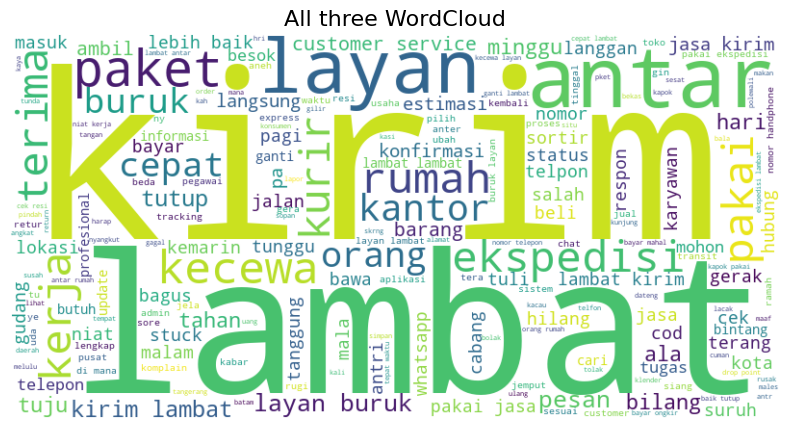

In [43]:
# Display wordcloud
generate_wordcloud(jelek_eda_df['processed_reviews'], 'All three WordCloud')

Dari visualisasi wordcloud diatas, dapat dilihat bahwa kata-kata yang sering muncul dalam review yang dikumpulkan adalah lambat dan kirim. Hal ini mengindikasikan bahwa kemungkinan besar adanya rating buruk diberikan oleh customer disebabkan karena keterlambatan pengiriman.

Selain itu, ditemukan pula beberapa kata lain seperti, ekspedisi, kecewa, layan, paket, antar, kurir, terima, kantor, cepat, rumah. Sehingga dari beberapa kata tersebut, hal lain yang mungkin menjadi penyebab rating yang rendah adalah pelanggan merasa kecewa karena pelayanan kurang baik dari kurir maupun pelayanan kantor atau juga kesalahan lokasi pengiriman.

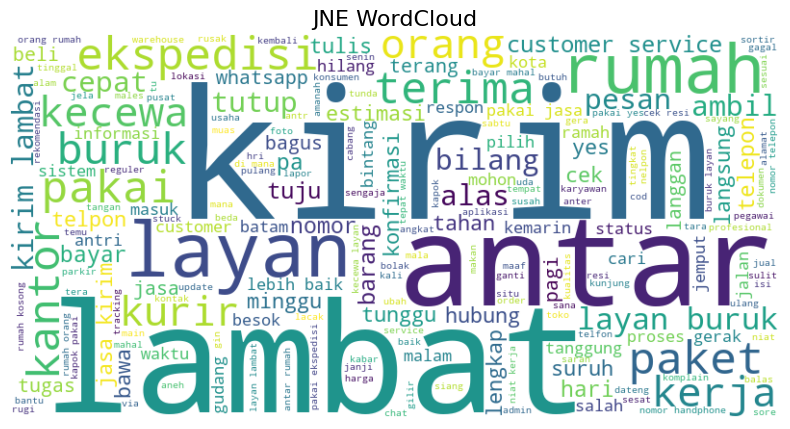

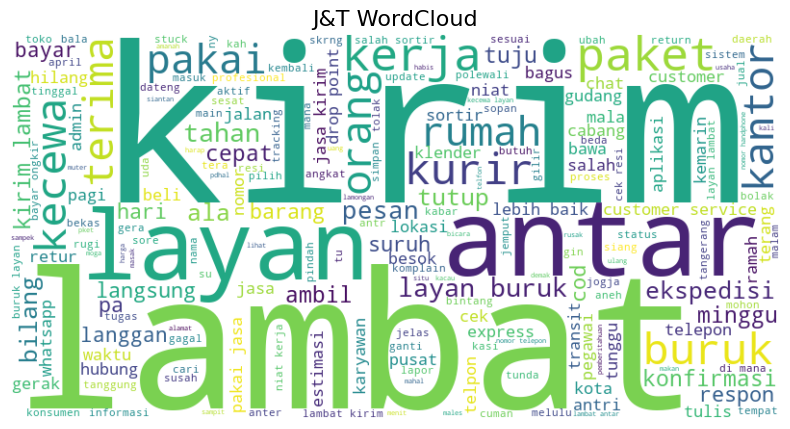

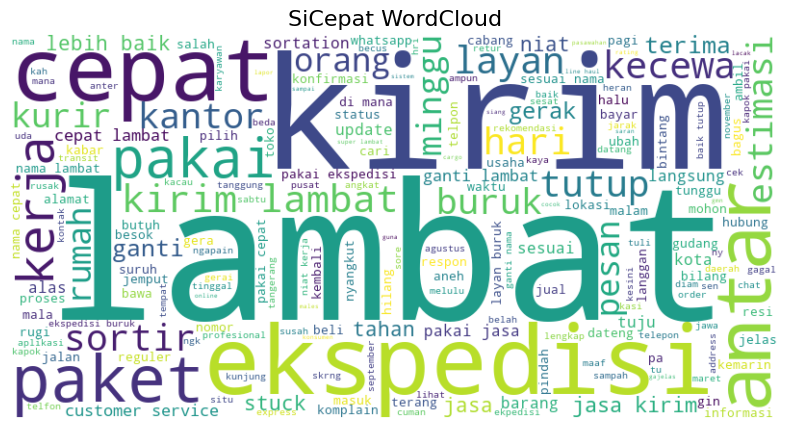

In [44]:
# Generate word clouds for each company
generate_wordcloud(jne_df['processed_reviews'], 'JNE WordCloud')
generate_wordcloud(jnt_df['processed_reviews'], 'J&T WordCloud')
generate_wordcloud(sicepat_df['processed_reviews'], 'SiCepat WordCloud')

Dari hasil visualisasi wordcloud tiap perusahaan JNE, J&T dan SiCepat, ketiganya memiliki lambat dan kirim sebagai kata yang sering muncul. Hal ini mengindikasikan bahwa keterlambatan pengiriman sepertinya menjadi masalah ketiga perusahaan ekspedisi.

In [45]:
# Check most used stopwords

def analyze_most_used_words(df, column, top_n=20):
    '''
    Check n top_n of most common words used.
    df = data
    column = column to be processed
    top_n = show top n words 
    '''
    # Tokenize the column into words
    df['words_list'] = df[column].apply(lambda x: str(x).split())
    
    # Flatten the list of lists and count word frequencies
    word_counts = Counter([word for words in df['words_list'] for word in words])
    
    # Create a DataFrame with the top N most common words
    most_common_df = pd.DataFrame(word_counts.most_common(top_n), columns=['word', 'count'])
    
    # Display the table with a gradient background for visualization
    return most_common_df.style.background_gradient(cmap='Blues')

Untuk membantu details jumlah kata pada wordcloud, maka berikut adalah perhitungan jumlah kata yang sering muncul dari keseluruhan dataset:

In [46]:
# Display most used words
print("Most Used Words for all three:")
analyze_most_used_words(jelek_eda_df, 'processed_reviews')

Most Used Words for all three:


,word,count
0,kirim,4095
1,lambat,3781
2,layan,2352
3,antar,1694
4,pakai,1627
5,buruk,1594
6,ekspedisi,1290
7,rumah,1143
8,kantor,1104
9,kerja,1074


Dari tampilan diatas ditemukan bahwa dari total ketiga perusahaan, kata-kata yang sering muncul adalah kirim, lambat, layan, antar, pakai dan buruk. Untuk analisa yang lebih detail, berikut adalah word count untuk masing-masing perusahaan:

In [47]:
# Most used words for JNE
print("Most Used Words for JNE:")
analyze_most_used_words(jne_df, 'processed_reviews')

Most Used Words for JNE:


,word,count
0,kirim,1599
1,lambat,1098
2,layan,987
3,pakai,626
4,buruk,620
5,antar,612
6,rumah,605
7,kantor,463
8,ekspedisi,425
9,orang,385


In [48]:
# Most used words for J&T
print("Most Used Words for J&T:")
analyze_most_used_words(jnt_df, 'processed_reviews')

Most Used Words for J&T:


,word,count
0,kirim,1541
1,lambat,1186
2,layan,1123
3,antar,727
4,buruk,725
5,kerja,544
6,pakai,509
7,kantor,463
8,paket,442
9,kecewa,430


In [49]:
# Most used words for Si Cepat
print("Most Used Words for SiCepat:")
analyze_most_used_words(sicepat_df, 'processed_reviews')

Most Used Words for SiCepat:


,word,count
0,lambat,1497
1,kirim,955
2,cepat,617
3,ekspedisi,555
4,pakai,492
5,antar,355
6,jasa,279
7,paket,252
8,buruk,249
9,layan,242


Dari hasil visualisasi di atas, diperoleh informasi bahwa, kata-kata yang mendominasi review dari ketiga ekspedisi tersebut adalah kirim, lambat.

### 9.1.2. bi/tri grams

Selanjutnya, dibuat fungsi untuk menghasilkan n-grams dari teks dalam kolom review di dataframe. Digunakan untuk menganalisis pola kata yang sering muncul dalam dataset teks yaitu ulasan pelanggan terhadap ekspedisi.

In [50]:
# Fungsi untuk menghasilkan bigram atau trigram

def get_ngrams(df, column, ngram_range, max_features=10):
    """
    Fungsi untuk menghasilkan n-grams (bigrams atau trigrams) dari teks dalam sebuah kolom DataFrame.

    Args:
        df (pd.DataFrame): DataFrame yang berisi teks.
        column (str): Nama kolom dalam DataFrame yang akan digunakan untuk analisis n-grams
        ngram_range (tuple): Rentang n-gram (misalnya, (2, 2) untuk bigrams, (3, 3) untuk trigrams)
        max_features (int, optional): Jumlah maksimum fitur (n-grams) yang dihasilkan. Default adalah 10

    Returns:
        list: Daftar n-grams (bigrams/trigrams) yang paling sering muncul berdasarkan input teks

    Proses:
        1. Menginisialisasi `CountVectorizer` dari scikit-learn untuk ekstraksi n-grams
        2. Menyesuaikan `CountVectorizer` dengan teks dalam kolom yang dipilih
        3. Mengembalikan daftar n-grams berdasarkan jumlah kemunculan terbanyak
    """

    # Inisialisasi CountVectorizer untuk menghasilkan n-grams
    vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=max_features)
    
    # Transformasikan teks dalam kolom DataFrame ke bentuk n-grams
    ngrams = vectorizer.fit_transform(df[column])

    # Kembalikan daftar fitur (n-grams) yang dihasilkan
    return vectorizer.get_feature_names_out()

In [51]:
# Iterasi untuk menghasilkan bigrams dan trigrams berdasarkan 'company'
for company in jelek_eda_df['company'].str.lower().unique():
    """
    Iterasi melalui setiap perusahaan dalam kolom 'company' untuk menghasilkan
    top 10 bigrams dan trigrams berdasarkan ulasan yang telah diproses.

    Args:
        jelek_eda_df (pd.DataFrame): DataFrame berisi ulasan pelanggan dengan kolom:
            - 'company': Nama perusahaan
            - 'processed_reviews': Teks ulasan yang sudah diproses
        company (str): Nama perusahaan yang sedang diproses dalam iterasi

    Proses:
        1. Memfilter data untuk perusahaan tertentu
        2. Menggunakan fungsi `get_ngrams` untuk menghasilkan:
           - Top 10 bigrams (n-gram dengan n=2)
           - Top 10 trigrams (n-gram dengan n=3)
        3. Menampilkan hasil bigrams dan trigrams untuk setiap perusahaan

    Returns:
        None: Fungsi ini hanya mencetak hasil bigrams dan trigrams saja
    """

    # Display header perusahaan
    print(f"\nTop 10 BIgrams for {company}:")

    # Filter DataFrame untuk perusahaan tertentu dan hasilkan bigrams
    bigrams = get_ngrams(jelek_eda_df[jelek_eda_df['company'].str.lower() == company], 'processed_reviews', (2, 2))
    print(bigrams)
    
    print(f"\nTop 10 TRIgrams for {company}:")
    trigrams = get_ngrams(jelek_eda_df[jelek_eda_df['company'].str.lower() == company], 'processed_reviews', (3, 3))
    print(trigrams)


Top 10 BIgrams for jne:
['customer service' 'jasa kirim' 'kirim lambat' 'lambat kirim'
 'layan buruk' 'lebih baik' 'nomor handphone' 'orang rumah' 'pakai jasa'
 'pakai yes']

Top 10 TRIgrams for jne:
['buruk kirim lambat' 'customer service pusat' 'layan buruk kirim'
 'lebih baik pakai' 'lebih baik tutup' 'makan gaji buta' 'nobody at home'
 'pakai jasa kirim' 'rumah kantor kosong' 'rumah kosong rumah']

Top 10 BIgrams for jnt:
['bayar ongkir' 'customer service' 'drop point' 'jasa kirim'
 'kirim lambat' 'lambat kirim' 'layan buruk' 'lebih baik' 'niat kerja'
 'pakai jasa']

Top 10 TRIgrams for jnt:
['bayar ongkir mahal' 'jasa kirim buruk' 'kapok pakai jasa'
 'layan buruk kirim' 'layan buruk kurir' 'lebih baik pakai'
 'lebih baik tutup' 'makan gaji buta' 'pakai jasa kirim'
 'telepon customer service']

Top 10 BIgrams for sicepat:
['cepat lambat' 'customer service' 'ganti lambat' 'jasa kirim'
 'kirim lambat' 'lambat kirim' 'layan buruk' 'lebih baik'
 'pakai ekspedisi' 'pakai jasa']

Top 10

Dari hasil BIgrams/TRIgrams setiap ekspedisi didapatkan bahwa:
1. JNE
    - Bigram:
        - Frasa seperti "kirim lambat" dan "layan buruk" menunjukkan keluhan utama pelanggan JNE adalah keterlambatan pengiriman dan kualitas layanan yang buruk.
        - Frasa seperti "pakai yes" dan "jasa kirim" menunjukkan bahwa ada masalah pada layanan JNE YES (yang seharusnya cepat tetapi tidak sesuai harapan).
    - Trigram:
        - Frasa seperti "buruk kirim lambat" dan "layan buruk kirim" menegaskan bahwa masalah utama di JNE secara general adalah pengiriman lambat dengan pelayanan yang kurang baik.
        - "lebih baik pakai" dan "lebih baik tutup" menunjukan frustrasi pelanggan yang tinggi.
        - Frasa seperti "nobody at home" atau "rumah kosong" menunjukkan bahwa mungkin ada masalah komunikasi antara kurir dan pelanggan terkait pengantaran.
    - Maka dapat diberi suggestion kepada JNE yaitu:
        - Memperbaiki proses pengiriman dengan mengoptimalkan rute pengiriman untuk mengurangi keterlambatan, terutama untuk JNE YES yang seharusnya pengirimannya tepat waktu. Selain itu, juga dapat meningkatkan kapasitas distribusi kurir di area yang memiliki volume pengiriman yang tinggi.
        - Meningkatkan layanan pelanggan dengan customer service yang jauh lebih responsif dan solutif. Karena terlihat bahwa "customer service pusat" sering disebut sebagai masalah.
        - Meningkatkan komunikasi antara pelanggan dan kurir. Misalnya, mengirim notifikasi otomatis sebelum pengiriman untuk memastikan penerima ada di tempat
2. J&T
    - Bigram:
        - Frasa seperti "bayar ongkir" dan "niat kerja" menunjukkan keluhan tentang ongkos kirim yang mahal dan perilaku kurir yang kurang profesional.
        - "layan buruk" dan "kirim lambat" menunjukkan masalah yang serupa dengan JNE, yaitu keterlambatan dan kualitas pelayanan.
    - Trigram:
        - Frasa seperti "bayar ongkir mahal" menegaskan bahwa banyak pelanggan merasa ongkos kirim J&T terlalu mahal dibandingkan kualitas layanan yang diberikan.
        - "kapok pakai jasa" dan "lebih baik tutup" menunjukkan tingkat kekecewaan pelanggan yang tinggi.
        - "layan buruk kurir" memperlihatkan keluhan tentang perilaku buruk kurir secara langsung.
    - Maka dapat diberi suggestion kepada J&T yaitu:
        - Mengevaluasi ongkos kirim: jika memungkinkan dapat mengurangi ongkos kirim atau memberi promosi/diskon pada layanan tertentu untuk meningkatkan kepuasan pelanggan.
        - Meningkatkan pelatihan kurir dimana dapat dilakukan pelatihan terhadap kurir terkait komunikasi, profesionalisme, dan cara menangani paket dengan baik.
        - Memastikan customer service memberi solusi yang cepat dan efektif untuk menangani keluhan pelanggan seperti keterlambatan atau perilaku kurir.
3. SiCepat
    - Bigram: 
        - Frasa seperti "cepat lambat" dan "ganti lambat" menunjukkan bahwa pelanggan kecewa karena pengiriman SiCepat yang seharusnya cepat tetapi pada kenyataannya lambat.
        - "layan buruk" kembali mendominasi, menunjukkan masalah yang konsisten pada layanan pelanggan.
    - Trigram:
        - Frasa seperti "jasa kirim lambat" dan "lebih baik ganti" menunjukkan ketidakpuasan dengan kecepatan pengiriman dan pelayanan umum.
        - "customer service suruh" dan "telepon customer service" menegaskan adanya masalah dengan respons customer service yang lambat atau tidak membantu.
        - "line haul darat" menunjukkan bahwa penggunaan jalur darat mungkin menjadi penyebab keterlambatan
    - Maka dapat diberi suggestion kepada SiCepat yaitu:
        - Memperbaiki kecepatan pengiriman dengan meningkatkan efisiensi pengiriman terutama di jalur darat (line haul) yang menjadi keluhan pelanggan.
        - Memastikan Customer service tersedia 24/7 untuk membantu pelanggan dengan cepat dan memberikan solusi yang memadai.
        - Mengomunikasikan estimasi waktu pengiriman yang realistis secara transparan kepada pelanggan.

Dari ketiga kurir ekspedisi tersebut terdapat persamaan masalah utama seperti:
- Keterlambatan pengiriman ("kirim lambat") menjadi keluhan utama pada semua kurir.
- Pelayanan buruk ("layan buruk") dan komunikasi yang tidak efektif memperburuk pengalaman pelanggan.
- Frustrasi pelanggan terlihat dari frasa seperti "lebih baik tutup" dan "kapok pakai jasa", menunjukkan pentingnya peningkatan layanan secara menyeluruh.

Maka saran untuk ketiga ekspedisi secara umum yaitu:
- Semua kurir perlu mengoptimalkan rute pengiriman untuk mengurangi keterlambatan, terutama di area yang sering terjadi keterlambatan.
- Pelatihan customer service dan kurir perlu ditingkatkan untuk memastikan layanan yang lebih profesional dan solutif.
- Adopsi teknologi untuk memberikan pembaruan status pengiriman secara real-time kepada pelanggan.
- Untuk memperbaiki hubungan dengan pelanggan, tawarkan kompensasi berupa diskon atau voucher kepada pelanggan yang mengalami keterlambatan atau masalah lainnya.

Dengan langkah tersebut, ketiga perusahaan ekspedisi dapat meningkatkan kepuasan pelanggan dan memperbaiki reputasi.

## 9.2. Bagus Modeling

In [52]:
# Replace NaN with an empty string and ensure all values are strings
bagus_jne_df['processed_reviews'] = bagus_jne_df['processed_reviews'].fillna('').astype(str)
bagus_jnt_df['processed_reviews'] = bagus_jnt_df['processed_reviews'].fillna('').astype(str)
bagus_sicepat_df['processed_reviews'] = bagus_sicepat_df['processed_reviews'].fillna('').astype(str)

bagus_eda_df['processed_reviews'] = bagus_eda_df['processed_reviews'].fillna('').astype(str)

### 9.2.1 WordCloud

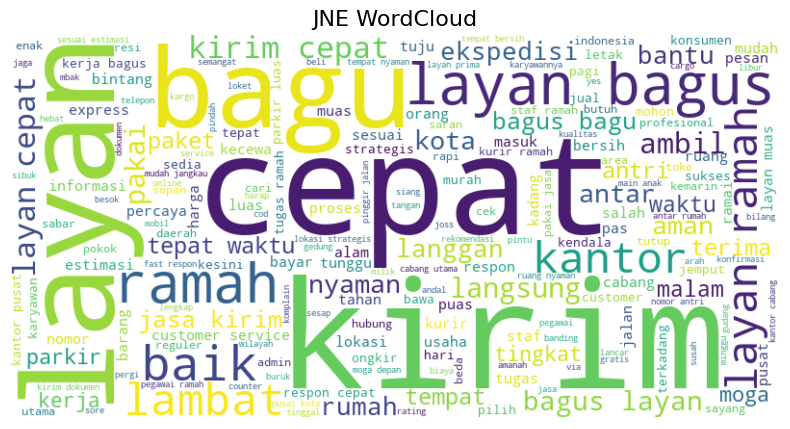

In [53]:
generate_wordcloud(bagus_eda_df['processed_reviews'], 'JNE WordCloud')

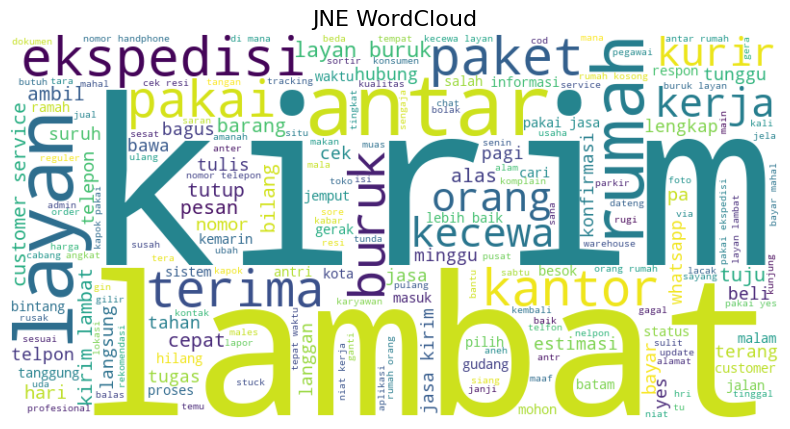

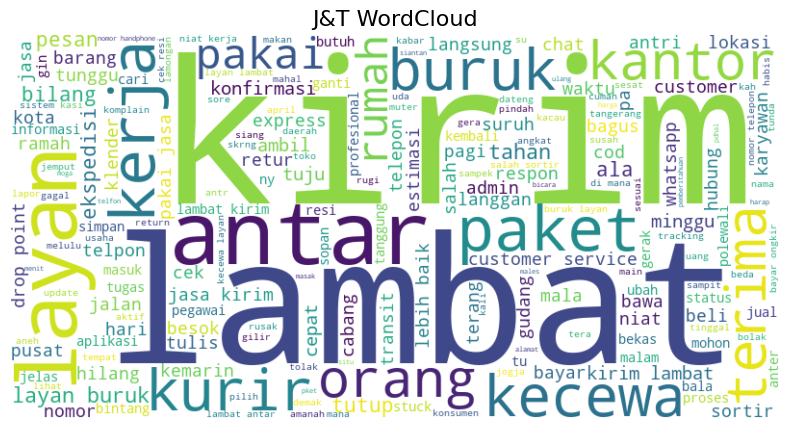

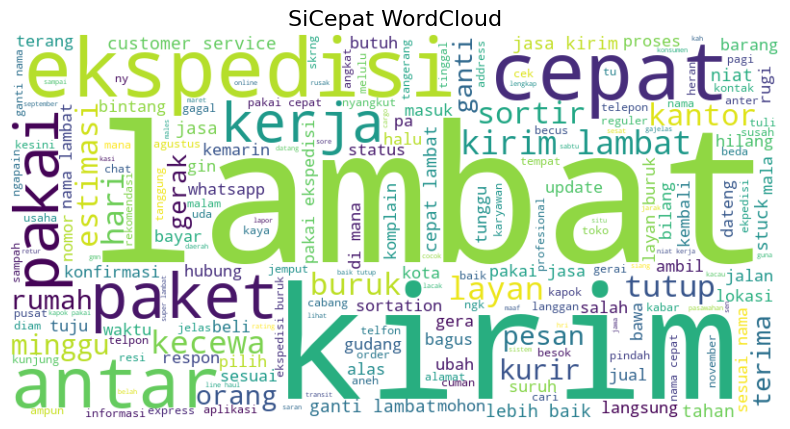

In [54]:
# Generate word clouds for each company
generate_wordcloud(jne_df['processed_reviews'], 'JNE WordCloud')
generate_wordcloud(jnt_df['processed_reviews'], 'J&T WordCloud')
generate_wordcloud(sicepat_df['processed_reviews'], 'SiCepat WordCloud')

Insights here

In [55]:
# Most used words for All three
print("Most Used Words for All three:")
analyze_most_used_words(bagus_eda_df, 'processed_reviews')

Most Used Words for All three:


,word,count
0,layan,1038
1,bagus,809
2,kirim,753
3,cepat,745
4,ramah,490
5,kantor,176
6,baik,170
7,lambat,164
8,pakai,149
9,jasa,142


In [56]:
# Most used words for JNE
print("Most Used Words for JNE:")
analyze_most_used_words(bagus_jne_df, 'processed_reviews')

Most Used Words for JNE:


,word,count
0,layan,712
1,bagus,499
2,kirim,473
3,cepat,395
4,ramah,327
5,nyaman,116
6,kantor,113
7,baik,111
8,lambat,98
9,antri,96


In [57]:
# Most used words for J&T
print("Most Used Words for J&T:")
analyze_most_used_words(bagus_jnt_df, 'processed_reviews')

Most Used Words for J&T:


,word,count
0,layan,272
1,bagus,235
2,cepat,218
3,kirim,205
4,ramah,141
5,jasa,46
6,kantor,45
7,baik,40
8,antar,39
9,waktu,39


In [58]:
# Most used words for SiCepat
print("Most Used Words for SiCepat:")
analyze_most_used_words(bagus_sicepat_df, 'processed_reviews')

Most Used Words for SiCepat:


,word,count
0,cepat,132
1,bagus,75
2,kirim,75
3,layan,54
4,lambat,34
5,pakai,32
6,langsung,24
7,ramah,22
8,rumah,21
9,sesuai,21


### 9.2.2 Bi / Tri grams

In [59]:
# Iterasi untuk menghasilkan bigrams dan trigrams berdasarkan 'company'
for company in jelek_eda_df['company'].str.lower().unique():
    """
    Iterasi melalui setiap perusahaan dalam kolom 'company' untuk menghasilkan
    top 10 bigrams dan trigrams berdasarkan ulasan yang telah diproses.

    Args:
        jelek_eda_df (pd.DataFrame): DataFrame berisi ulasan pelanggan dengan kolom:
            - 'company': Nama perusahaan
            - 'processed_reviews': Teks ulasan yang sudah diproses
        company (str): Nama perusahaan yang sedang diproses dalam iterasi

    Proses:
        1. Memfilter data untuk perusahaan tertentu
        2. Menggunakan fungsi `get_ngrams` untuk menghasilkan:
           - Top 10 bigrams (n-gram dengan n=2)
           - Top 10 trigrams (n-gram dengan n=3)
        3. Menampilkan hasil bigrams dan trigrams untuk setiap perusahaan

    Returns:
        None: Fungsi ini hanya mencetak hasil bigrams dan trigrams saja
    """

    # Display header perusahaan
    print(f"\nTop 10 BIgrams for {company}:")

    # Filter DataFrame untuk perusahaan tertentu dan hasilkan bigrams
    bigrams = get_ngrams(jelek_eda_df[jelek_eda_df['company'].str.lower() == company], 'processed_reviews', (2, 2))
    print(bigrams)
    
    print(f"\nTop 10 TRIgrams for {company}:")
    trigrams = get_ngrams(jelek_eda_df[jelek_eda_df['company'].str.lower() == company], 'processed_reviews', (3, 3))
    print(trigrams)


Top 10 BIgrams for jne:
['customer service' 'jasa kirim' 'kirim lambat' 'lambat kirim'
 'layan buruk' 'lebih baik' 'nomor handphone' 'orang rumah' 'pakai jasa'
 'pakai yes']

Top 10 TRIgrams for jne:
['buruk kirim lambat' 'customer service pusat' 'layan buruk kirim'
 'lebih baik pakai' 'lebih baik tutup' 'makan gaji buta' 'nobody at home'
 'pakai jasa kirim' 'rumah kantor kosong' 'rumah kosong rumah']

Top 10 BIgrams for jnt:
['bayar ongkir' 'customer service' 'drop point' 'jasa kirim'
 'kirim lambat' 'lambat kirim' 'layan buruk' 'lebih baik' 'niat kerja'
 'pakai jasa']

Top 10 TRIgrams for jnt:
['bayar ongkir mahal' 'jasa kirim buruk' 'kapok pakai jasa'
 'layan buruk kirim' 'layan buruk kurir' 'lebih baik pakai'
 'lebih baik tutup' 'makan gaji buta' 'pakai jasa kirim'
 'telepon customer service']

Top 10 BIgrams for sicepat:
['cepat lambat' 'customer service' 'ganti lambat' 'jasa kirim'
 'kirim lambat' 'lambat kirim' 'layan buruk' 'lebih baik'
 'pakai ekspedisi' 'pakai jasa']

Top 10

# 10. Features Preparation

Pada langkah ini nantinya data review akan dibagi menjadi dua kelompok berdasarkan rating bintangnya. Yaitu rating 1-3 bintang akan menjadi model jelek dan rating 4-5 bintang akan menjadi model bagus.

In [60]:
# load file untuk membaca data preprocessed yang sudah bersih
with open('prepro_cleaned_reviews.csv', 'r') as file_prepro:
    eda_df = pd.read_csv(file_prepro)

In [61]:
# baca data csv
df = pd.read_csv('prepro_cleaned_reviews.csv')

In [62]:
# display data
df

,rating,reviews,company,province,parsed_date,processed_reviews
0,5,"Located at the Padang Old City area, just arou...",JNE,Aceh,2024-04-25,letak kawasan kota tua jembatan siti nurbaya s...
1,1,"Bad service given to customers, my own experie...",JNE,Aceh,2021-01-21,layan buruk langgan alam ambil jasa kirim kelu...
2,5,"Nice Place, they're working on rebuild their o...",JNE,Aceh,2022-01-21,bagus upaya bangun kantor orang orang hebat layan
3,5,Good delivery service for customers in this co...,JNE,Aceh,2023-01-21,kirim langgan negara
4,5,Good service,JNE,Aceh,2022-01-21,layan bagus
...,...,...,...,...,...,...
17659,1,Kargo Silambat,Sicepat,Sumatera Utara,2021-01-21,kargo lambat
17660,1,SILELET CEMBRETTTTTT,Sicepat,Sumatera Utara,2021-01-21,lambat cembret
17661,1,Lambat sekali....,Sicepat,Sumatera Utara,2021-01-21,lambat
17662,1,KERAS!!!!!,Sicepat,Sumatera Utara,2021-01-21,keras


In [63]:
# buat salinan data
modeling_df = df.copy()

In [64]:
# memisahkan data berdasarkan rating 
jelek_modeling = modeling_df.query("rating <= 3" ) # Ulasan dengan rating buruk (<= 3) sebagai jelek_modeling
bagus_modeling = modeling_df.query("rating >= 4") # Ulasan dengan rating baik (>= 4) sebagai bagus_modeling

Data berhasil dibagi menjadi dua subset:
- jelek_modeling berisi ulasan dengan rating 3 atau lebih rendah. Dimana ini dipisahkan untuk analisis lebih lanjut untuk mengetahui keluhan pelanggan kepada ekspedisi yang digunakan dan melakukan clustering topic lanjutan.
- bagus_modeling berisi ulasan dengan rating 4 atau lebih tinggi. Ini dipisahkan untuk mengetahui apa faktor yang membuat ekspedisi tersebut disukai pelanggan untuk analisis dan clustering ulasan positif.

In [65]:
print(jelek_modeling.shape)
print(bagus_modeling.shape)

(13927, 6)
(3737, 6)


Dari hasil pemisahan didapatkan ada sejumlah 13.927 data yang merupakan ulasan negatif dan hanya ada 3.737 data yang merupakan ulasan positif dari pelanggan untuk ketiga ekspedisi.

## 10.1. Jelek Modeling

Untuk melihat bagaimana atau faktor apa yang dikeluhkan oleh pelanggan serta memberi saran untuk perbaikan dari 3 ekspedisi yaitu JNE, J&T, dan SiCepat di berbagai provinsi di Indonesia, maka diperlukan modeling dan analisis terhadap data yang memiliki rating bintang 1-3.

In [66]:
# Ensure the 'processed_reviews' column is treated as string
jelek_modeling['processed_reviews'] = jelek_modeling['processed_reviews'].astype(str)

# Tokenize the processed_reviews column
jelek_modeling['tokenized_reviews'] = jelek_modeling['processed_reviews'].apply(word_tokenize)

- Mengubah kolom processed_reviews menjadi tipe data string untuk menghindari masalah saat memproses teks sehingga teks siap untuk diproses lebih lanjut seperti tokenisasi.
- Lalu melakukan tokenisasi pada setiap ulasan dalam kolom processed_reviews dan menyimpannya dalam kolom baru tokenized_reviews. Dimana proses ini sangat penting pada NLP untuk memecah teks menjadi unit-unit yang lebih kecil, yang disebut token. Token biasanya berupa kata atau simbol dalam teks. Setelah tokenisasi, setiap ulasan yang sebelumnya berupa string akan diubah menjadi daftar kata atau token. Misalnya, kalimat "kargo lambat" diubah menjadi ['kargo','lambat']. Dengan mengubah teks menjadi token, analisis dan pembuatan model berbasis kata dapat dilakukan lebih mudah.


In [67]:
# display ulasan negatif setelah proses tokenisasi
jelek_modeling

,rating,reviews,company,province,parsed_date,processed_reviews,tokenized_reviews
1,1,"Bad service given to customers, my own experie...",JNE,Aceh,2021-01-21,layan buruk langgan alam ambil jasa kirim kelu...,"[layan, buruk, langgan, alam, ambil, jasa, kir..."
7,1,Too slow,JNE,Aceh,2016-01-23,lambat,[lambat]
18,2,Slow service,JNE,Aceh,2022-01-21,lambat,[lambat]
20,1,Bad service,JNE,Aceh,2019-01-22,buruk,[buruk]
24,1,The courier was too slow for many reasons even...,JNE,Aceh,2025-01-06,kurir lambat kira pakai sayang m,"[kurir, lambat, kira, pakai, sayang, m]"
...,...,...,...,...,...,...,...
17658,1,Lambat,Sicepat,Sumatera Utara,2021-01-21,lambat,[lambat]
17659,1,Kargo Silambat,Sicepat,Sumatera Utara,2021-01-21,kargo lambat,"[kargo, lambat]"
17660,1,SILELET CEMBRETTTTTT,Sicepat,Sumatera Utara,2021-01-21,lambat cembret,"[lambat, cembret]"
17661,1,Lambat sekali....,Sicepat,Sumatera Utara,2021-01-21,lambat,[lambat]


In [68]:
# mengonversi kolom tokenized_reviews menjadi sebuah daftar dan kemudian membuat dictionary berdasarkan token
tokenized_reviews = jelek_modeling['tokenized_reviews'].tolist()  # Convert the column to a list of lists
dictionary = Dictionary(tokenized_reviews)

- Biasanya kolom tokenized_reviews berisi daftar kata (token) untuk setiap ulasan. Dengan mengubahnya menjadi list of lists sehingga memiliki struktur data yang lebih fleksibel untuk diproses lebih lanjut, seperti membuat model machine learning atau analisis teks.
- Dictionary ini adalah langkah penting dalam banyak teknik pemrosesan teks, seperti Latent Dirichlet Allocation (LDA) untuk topik modeling dan menemukan topik tersembunyi dalam data teks.

In [69]:
# Print dictionary information
print(f"Dictionary created with {len(dictionary)} unique tokens.")

Dictionary created with 10834 unique tokens.


Artinya, 10834 kata unik telah ditemukan dan dimasukkan ke dalam kamus dari data ulasan jelek yang telah diproses.

Kemudian, hitung dan urutkan kata-kata berdasarkan frekuensi kemunculannya di seluruh dataset, sehingga mempermudah untuk melihat kata yang paling sering muncul dalam teks yang dianalisis.

In [70]:
# Word counts
word_counts = dictionary.cfs  # cfs = term frequency across the corpus
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

Lalu kode berikut ini untuk menghitung frekuensi kumulatif untuk setiap kata berdasarkan urutan frekuensinya, yang menunjukkan jumlah total kata yang muncul hingga posisi tertentu dalam daftar yang sudah diurutkan. 

In [71]:
# Cumulative frequency
word_frequencies = [count for _, count in sorted_word_counts]
cumulative_frequencies = [sum(word_frequencies[:i]) for i in range(1, len(word_frequencies) + 1)]

 Dibuat grafik distribusi frekuensi kumulatif untuk ukuran kosakata (jumlah kata yang berbeda) dan jumlah frekuensi kumulatif kata, yang berguna untuk visualisasi distribusi kata dalam dataset teks. Grafik ini dapat menunjukkan bagaimana frekuensi kata tersebar seiring bertambahnya jumlah kata dalam kosakata.

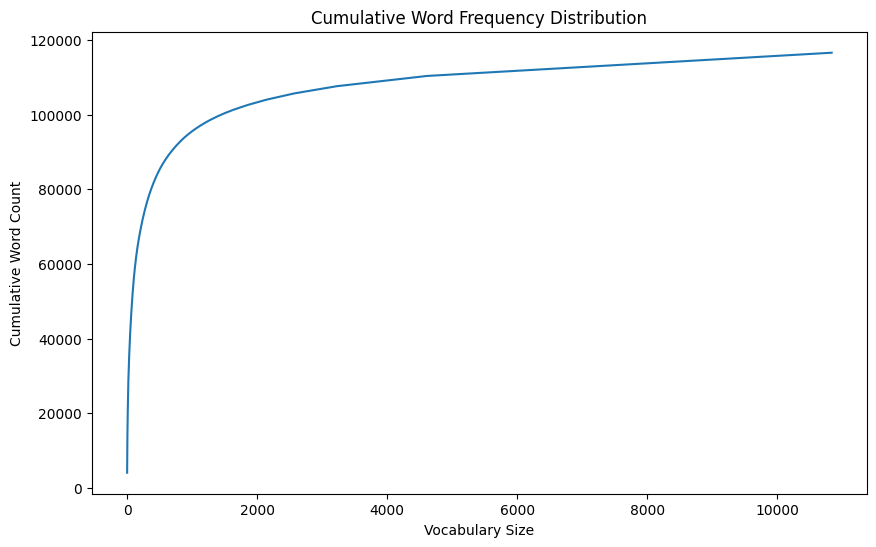

In [72]:
# plot distribusi frekuensi kumulatif kata dataset jelek
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_frequencies) + 1), cumulative_frequencies)
plt.xlabel('Vocabulary Size')
plt.ylabel('Cumulative Word Count')
plt.title('Cumulative Word Frequency Distribution')
plt.show()

- Distribusi Long Tail: Grafik ini menunjukkan distribusi frekuensi kumulatif kata yang khas, di mana sebagian besar kata muncul sangat sedikit kali, sementara beberapa kata muncul sangat sering. Hal ini adalah karakteristik distribusi long tail yang sering ditemukan dalam teks.
- "Jatuh tajam" yang terjadi pada bagian awal grafik menggambarkan bahwa sebagian besar frekuensi kata didominasi oleh beberapa kata yang sangat sering muncul. Setelah titik tertentu, kurva cenderung mendatar, menunjukkan bahwa meskipun kosakata bertambah, jumlah kemunculan kata baru menurun.
- Beberapa kata yang sering muncul di awal kosakata bertanggung jawab atas sebagian besar frekuensi kumulatif. 

Kemudian, hitung panjang ulasan (dalam jumlah kata), visualisasikan distribusi panjang ulasan menggunakan histogram, dan tampilkan statistik deskriptif untuk memberikan gambaran lebih jelas tentang distribusi panjang ulasan dalam dataset.

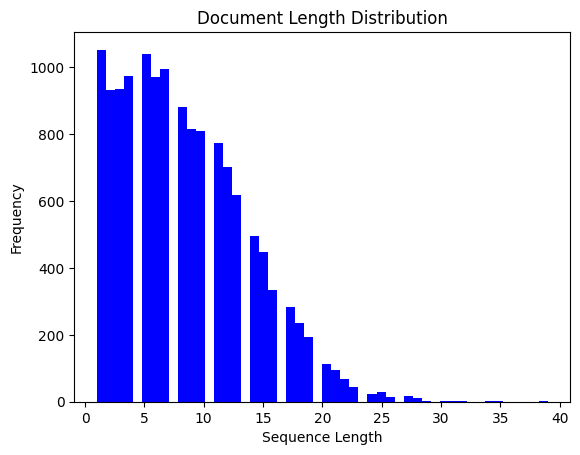

count    13927.000000
mean         8.373160
std          5.362486
min          1.000000
25%          4.000000
50%          8.000000
75%         12.000000
90%         16.000000
95%         18.000000
max         39.000000
Name: tokenized_reviews, dtype: float64


In [73]:
# hitung panjang urutan (jumlah kata) di setiap ulasan
sequence_lengths = jelek_modeling['tokenized_reviews'].apply(len)

# Plot sequence length distribution by histogram
plt.hist(sequence_lengths, bins=50, color='blue')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Document Length Distribution')
plt.show()

# Print descriptive stats
print(sequence_lengths.describe(percentiles=[0.25, 0.5, 0.75, 0.90, 0.95]))

- Grafik menunjukkan distribusi panjang ulasan jelek yang cenderung terdistribusi secara skewed, di mana sebagian besar ulasan memiliki panjang antara 1 hingga 10 kata. Kemudian, distribusi panjang urutan semakin jarang seiring dengan meningkatnya panjang ulasan.
- Sebagian besar ulasan cenderung pendek dan mungkin lebih berbentuk komentar singkat atau rating tanpa penjelasan panjang.
- Sebagian besar ulasan memiliki panjang antara 1 hingga 18 kata.
- Ulasan dengan panjang sangat pendek (1-4 kata) sangat dominan dalam dataset.
- Ada beberapa ulasan yang sangat panjang, namun sangat jarang ditemukan.
- Count (13927): Dataset memiliki 13,927 ulasan.
- Mean (8.37): Rata-rata panjang ulasan adalah sekitar 8 kata.
- Std (5.36): Deviasi standar panjang ulasan adalah 5.36 kata, menunjukkan variasi yang cukup besar dalam panjang ulasan.
- Panjang urutan terpendek adalah 1 kata (ulasan sangat pendek) dan terpanjang adalah 39 kata.

Disini, hitung word coverage atau cakupan kata berdasarkan 5000 kata teratas yang paling sering muncul dalam dataset.

In [74]:
top_n = 5000  # Adjust berdasarkan "Cumulative Word Frequency Distribution"
word_coverage = sum([freq for _, freq in sorted_word_counts[:top_n]]) / sum(word_frequencies)
print(f"Word Coverage with top {top_n} words: {word_coverage:.2%}")

Word Coverage with top 5000 words: 95.00%


- Cakupan kata dengan 5000 kata teratas adalah 95%, yang berarti 95% dari semua kemunculan kata dalam dataset dapat dijelaskan hanya dengan menggunakan 5000 kata yang paling sering muncul.
- Dimana menunjukan bahwa sebagian besar informasi dalam dataset dapat digambarkan dengan hanya sebagian kecil dari total kosakata.

In [75]:
# filter kata dalam dictionary berdasarkan frekuensi kemunculan
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=5000)
print(f"Filtered dictionary size: {len(dictionary)}")

Filtered dictionary size: 2039


parameter yang digunakan:
- no_below=5: Hanya kata-kata yang muncul lebih dari 5 kali dalam dataset yang akan dipertahankan. Kata-kata yang muncul kurang dari 5 kali akan dihapus dari kamus.
- no_above=0.5: Hanya kata-kata yang muncul pada kurang dari 50% dokumen yang akan dipertahankan. Kata-kata yang muncul di lebih dari 50% dokumen akan dihapus dari kamus.
- keep_n=5000: Membatasi kamus agar hanya menyimpan 5000 kata teratas yang paling sering muncul setelah pemfilteran berdasarkan frekuensi kata.

Hasil:
- Setelah pemfilteran, kamus hanya berisi 2039 kata yang sering muncul, lebih informatif, dan relevan.
- Pemfilteran ini mengurangi ukuran kamus dari jumlah kata semula (lebih banyak kata) menjadi kata-kata yang lebih relevan dan sering muncul, serta menghapus kata-kata yang terlalu jarang atau terlalu sering muncul.

Lalu, konversi setiap ulasan yang telah ditokenisasi ke dalam format Bag of Words (BoW), di mana setiap ulasan diwakili oleh daftar pasangan (kata_id, frekuensi) yang dapat digunakan dalam analisis atau pemodelan teks, seperti clustering.

In [76]:
# membuat bag of words
corpus = [dictionary.doc2bow(review) for review in tokenized_reviews]

Buat model Latent Dirichlet Allocation (LDA) untuk topic modeling pada dataset ulasan yang jelek. Dimana LDA menggunakan parameter seperti jumlah topik, jumlah iterasi, dan batch size untuk melatih model dan menemukan pola tersembunyi dalam data teks.

In [77]:
lda_model = LdaModel(corpus=corpus, 
                     id2word=dictionary,
                     alpha='auto',
                     eta='auto',
                     iterations=200, 
                     num_topics=3, 
                     chunksize=500, 
                     passes=100, 
                     random_state=37)

- Menyediakan corpus (representasi Bag of Words) yang telah dibuat sebelumnya sebagai input untuk LDA.
- Menyediakan kamus (dictionary) yang menghubungkan ID kata dengan kata-kata asli, sehingga model LDA dapat menginterpretasikan ID kata menjadi kata-kata yang sesuai.
- Menggunakan nilai alpha otomatis untuk mengontrol distribusi topik pada dokumen. Nilai ini mengatur seberapa banyak dokumen akan memiliki lebih dari satu topik
- Menggunakan nilai eta otomatis untuk mengontrol distribusi kata dalam topik. Seperti alpha yang membantu model menyesuaikan parameter yang mengatur seberapa banyak kata yang akan muncul dalam setiap topik.
- Jumlah iterasi yaitu 200 yang akan dilakukan selama pelatihan LDA. Semakin banyak iterasi, semakin baik model akan konvergen, tetapi memerlukan waktu lebih lama.
- Menentukan jumlah topik yang ingin dihasilkan oleh model LDA. Di sini, model akan mencoba menemukan 3 topik yang tersembunyi dalam dataset.
- Menentukan ukuran batch yaitu 500 (jumlah dokumen yang diproses dalam sekali iterasi) saat pelatihan model.
- passes=100 untuk menentukan berapa kali model akan mengulang seluruh corpus selama pelatihan.

In [78]:
# identifikasi oleh model LDA untuk menunjukan tiga topik utama berdasarkan distribusi kata di dataset
for i, topic in lda_model.show_topics(num_topics=4, num_words=30, formatted=False):
    print(f"Topic {i + 1}:")
    print(" ".join([word for word, _ in topic]))
    print()

Topic 1:
layan buruk kerja tutup ganti customer baik alas bayar service niat lebih suruh ambil malas beli kembali pusat cod pagi rugi langgan cabang jual mahal ongkir ramah nan profesional pindah

Topic 2:
lambat kirim pakai antar ekspedisi cepat paket jasa kecewa sortir estimasi pesan tuju hari tahan minggu nama kota sesuai waktu barang jalan gerak salah respon butuh bagus stuck hilang tunggu

Topic 3:
kantor rumah orang nomor kurir terima telepon bilang langsung cek konfirmasi resi pas telpon whatsapp mana bawa hubung masuk terang cari tulis angkat di informasi handphone aplikasi jemput sopan tu



LDA berhasil mengidentifikasi beberapa masalah utama yang dihadapi pelanggan terkait dengan layanan pengiriman, seperti keterlambatan, komunikasi yang buruk, dan biaya pengiriman yang mahal.

- Topik 1 berfokus pada masalah terkait dengan kualitas pelayanan pelanggan yang buruk dan tindakan yang perlu diambil untuk memperbaiki situasi, seperti menutup layanan, mengganti kurir atau service, dan masalah harga dan ongkir. Kata-kata utama: layan buruk (layanan buruk), customer, mahal ongkir (ongkos kirim mahal), ganti (mengganti).
- Topik 2 berkaitan dengan keluhan tentang keterlambatan pengiriman, masalah ongkos kirim, dan ketidakpuasan terhadap estimasi waktu pengiriman. Ada juga keluhan mengenai paket yang hilang atau stuck selama proses pengiriman. Kata-kata utama: lambat kirim (pengiriman lambat), paket, estimasi, tunggu, kecewa.
- Topik 3 berkaitan pada masalah komunikasi kurir dan pengiriman, dengan banyak kata yang berkaitan dengan komunikasi antara kurir dan penerima, seperti telepon, cek resi, dan hubungan dengan customer service. Kata-kata utama: telepon, kurir, cek resi, whatsapp, handphone.

Untuk evaluasi bisa dihitung coherence score dari model LDA untuk dataset jelek_modeling. Coherence Score adalah metrik yang digunakan untuk mengukur kualitas topik yang dihasilkan oleh model Latent Dirichlet Allocation (LDA). Skor koherensi ini mengukur seberapa baik kata-kata dalam topik-topik yang dihasilkan oleh model LDA saling terkait. Skor yang lebih tinggi menunjukkan bahwa kata-kata dalam topik tersebut sering muncul

In [79]:
# Menghitung coherence score untuk model LDA
coherence_model = CoherenceModel(model=lda_model, texts=jelek_modeling['tokenized_reviews'], dictionary=dictionary, coherence='c_v')

# Mendapatkan nilai coherence score
coherence_score = coherence_model.get_coherence()

In [80]:
# Menampilkan coherence score untuk dataset ulasan jelek
print(f"Coherence Score: {coherence_score}")

Coherence Score: 0.45900820455701735


Skor: 0.459 menunjukkan bahwa model LDA menghasilkan topik-topik yang cukup koheren, tetapi masih dapat dioptimalkan dan diperbaiki. Skor sekitar 0.4 - 0.6 dianggap sebagai skor yang baik dalam kebanyakan kasus, menunjukkan bahwa topik-topik yang dihasilkan memiliki koherensi yang cukup baik tetapi tidak sempurna.

Lalu digunakan juga library pyLDAvis untuk visuasisasi topik LDS untuk memahami topik-topik yang dihasilkan oleh model Latent Dirichlet Allocation (LDA) secara interaktif.

In [81]:
# buat data visualisasi topik dari model LDA yang telah dilatih dengan gensim
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

In [82]:
# assign label per topic
topic_labels = {
    0: "Kualitas Pelayan Buruk",
    1: "Delay/ Lambat Pengiriman",
    2: "Komunikasi Kurir"
}

- Topik 0 diberikan label "Kualitas Pelayan Buruk", yang berhubungan dengan keluhan tentang layanan pelanggan yang buruk, berdasarkan kata-kata yang paling sering muncul dalam topik tersebut.
- Topik 1 diberikan label "Delay/ Lambat Pengiriman", yang kemungkinan berfokus pada keluhan mengenai keterlambatan pengiriman.
- Topik 2 diberikan label "Komunikasi Kurir", yang mungkin berfokus pada masalah komunikasi antara kurir dan pelanggan, misalnya tentang konfirmasi alamat atau pengiriman.

Proses selanjutnya ini memberi label pada setiap dokumen dengan topik yang paling relevan, sehingga lebih mudah untuk menganalisis data berdasarkan topik-topik utama yang ditemukan dalam model LDA.

In [83]:
# Assign labels to each documents
doc_topics = [max(lda_model.get_document_topics(doc), key=lambda x: x[1])[0] for doc in corpus]
jelek_modeling['topic'] = [topic_labels[topic] for topic in doc_topics]

In [84]:
# # Save labeled documents
# jelek_modeling.to_csv("labeled_documents.csv", index=False)

In [85]:
# menunjukkan distribusi jumlah dokumen untuk setiap topik yang telah diberi label menggunakan LDA
jelek_modeling['topic'].value_counts()

topic
Delay/ Lambat Pengiriman    10113
Kualitas Pelayan Buruk       2232
Komunikasi Kurir             1582
Name: count, dtype: int64

- Jadi, topik "Delay/ Lambat Pengiriman" memiliki 10,113 dokumen yang terkait dengan keluhan tentang keterlambatan pengiriman. Ini adalah topik yang paling dominan dalam dataset, menunjukkan bahwa sebagian besar keluhan pelanggan berkaitan dengan pengiriman yang lambat.
- Topik "Kualitas Pelayan Buruk" memiliki 2,232 dokumen yang membahas masalah pelayanan yang buruk. Meskipun tidak sebanyak topik pengiriman lambat, topik ini juga menunjukkan masalah penting terkait dengan pelayanan pelanggan.
- Topik "Komunikasi Kurir" memiliki 1,582 dokumen yang mengangkat masalah terkait komunikasi antara kurir dan pelanggan yang menunjukan bahwa banyak keluhan terkait dengan cara kurir berkomunikasi, termasuk masalah koordinasi dan pemberitahuan pengiriman.
- Dataset ulasan jelek ini menunjukkan bahwa pelanggan lebih cenderung mengeluh tentang keterlambatan pengiriman, diikuti oleh masalah dengan pelayanan dan komunikasi kurir.
- Fokus perbaikan dapat diarahkan pada pengurangan keterlambatan pengiriman, meningkatkan kualitas layanan pelanggan, dan memperbaiki komunikasi dengan kurir untuk meningkatkan kepuasan pelanggan secara keseluruhan.


In [86]:
# untuk melihat nilai unik yang ada di kolom 'company' dalam dataset jelek_modeling
jelek_modeling['company'].unique()

array(['JNE', 'JNT', 'Sicepat'], dtype=object)

Dataset ini mencakup tiga perusahaan pengiriman, yaitu JNE, JNT, dan Sicepat. Jadi dataset jelek ini berisi keluhan pelanggan terkait layanan dari ketiga perusahaan ekspedisi tersebut.

## 10.2. Bagus Modeling

Untuk melihat bagaimana atau faktor apa yang membuat pelanggan puas dengan 3 ekspedisi yaitu JNE, J&T, dan SiCepat di berbagai provinsi di Indonesia, maka diperlukan modeling dan analisis terhadap data yang memiliki rating bintang 4-5.

In [87]:
# display dataset dengan ulasan yang bagus
bagus_modeling

,rating,reviews,company,province,parsed_date,processed_reviews
0,5,"Located at the Padang Old City area, just arou...",JNE,Aceh,2024-04-25,letak kawasan kota tua jembatan siti nurbaya s...
2,5,"Nice Place, they're working on rebuild their o...",JNE,Aceh,2022-01-21,bagus upaya bangun kantor orang orang hebat layan
3,5,Good delivery service for customers in this co...,JNE,Aceh,2023-01-21,kirim langgan negara
4,5,Good service,JNE,Aceh,2022-01-21,layan bagus
5,5,Very nice building and nice staff,JNE,Aceh,2023-01-21,bangun bagus staf
...,...,...,...,...,...,...
17647,5,Komplek pergudangan 👍👍 …,Sicepat,Sumatera Utara,2021-01-21,komplek gudang
17650,5,Semangat,Sicepat,Sumatera Utara,2021-01-21,semangat
17655,5,Kerja bagus,Sicepat,Sumatera Utara,2021-01-21,kerja bagus
17656,5,Bagus,Sicepat,Sumatera Utara,2021-01-21,bagus


In [88]:
# hitung jumlah data dengan rating 4 dan 5 yang ada dalam dataset bagus
bagus_modeling['rating'].value_counts()

rating
5    2783
4     954
Name: count, dtype: int64

In [89]:
# Ensure the 'processed_reviews' column is treated as string
bagus_modeling['processed_reviews'] = bagus_modeling['processed_reviews'].astype(str)

# Tokenize the processed_reviews column
bagus_modeling['tokenized_reviews'] = bagus_modeling['processed_reviews'].apply(word_tokenize)

- pada dataset bagus_modeling ini, memastikan bahwa semua nilai dalam kolom processed_reviews diperlakukan sebagai string agar dapat diproses dengan benar, terutama jika ada nilai yang tidak konsisten (misalnya, angka atau NaN)
- lalu gunakan fungsi word_tokenize untuk memecah setiap ulasan dalam kolom processed_reviews menjadi daftar kata (token) untuk analisis teks lebih lanjut

In [90]:
tokenized_reviews2 = bagus_modeling['tokenized_reviews'].tolist()  # Convert the column to a list of lists
dictionary2 = Dictionary(tokenized_reviews2)

- seperti di dataset jelek, ini dilakukan juga untuk dataset bagus dimana mengonversi kolom tokenized_reviews yang berisi daftar token menjadi list of lists untuk setiap ulasan dan membuat kamus (dictionary) baru menggunakan tokenized_reviews2, yang memetakan setiap kata unik ke ID numeriknya

In [91]:
# Print dictionary information
print(f"Dictionary created with {len(dictionary2)} unique tokens.")

Dictionary created with 2922 unique tokens.


menunjukkan bahwa kamus yang dibuat memiliki 2922 kata unik yang digunakan dalam dataset. Ini berarti ada 2922 kata berbeda yang ditemukan setelah memproses data, dan setiap kata tersebut diberi ID numerik untuk analisis lebih lanjut.

In [92]:
# Word counts
word_counts2 = dictionary2.cfs  # cfs = term frequency across the corpus
sorted_word_counts2 = sorted(word_counts2.items(), key=lambda x: x[1], reverse=True)

- Mengambil frekuensi kemunculan kata (term frequency) untuk setiap kata yang ada dalam kamus dictionary2. Hasilnya adalah jumlah kemunculan setiap kata di seluruh corpus.
- Menyortir daftar frekuensi kata dari word_counts2 berdasarkan jumlah kemunculannya (x[1]) secara menurun, sehingga kata yang paling sering muncul berada di urutan pertama.

In [93]:
# Cumulative frequency
word_frequencies2 = [count for _, count in sorted_word_counts2]
cumulative_frequencies2 = [sum(word_frequencies2[:i]) for i in range(1, len(word_frequencies2) + 1)]

- Mengambil frekuensi kata (nilai count) dari daftar sorted_word_counts2 yang sudah diurutkan, menyimpannya dalam list word_frequencies2.
- lalu, membuat frekuensi kumulatif dengan menjumlahkan frekuensi kata secara bertahap, mulai dari kata pertama hingga kata ke-i. Hasilnya disimpan dalam cumulative_frequencies2, menunjukkan total kemunculan kata hingga titik tertentu dalam urutan kata yang sudah disortir.

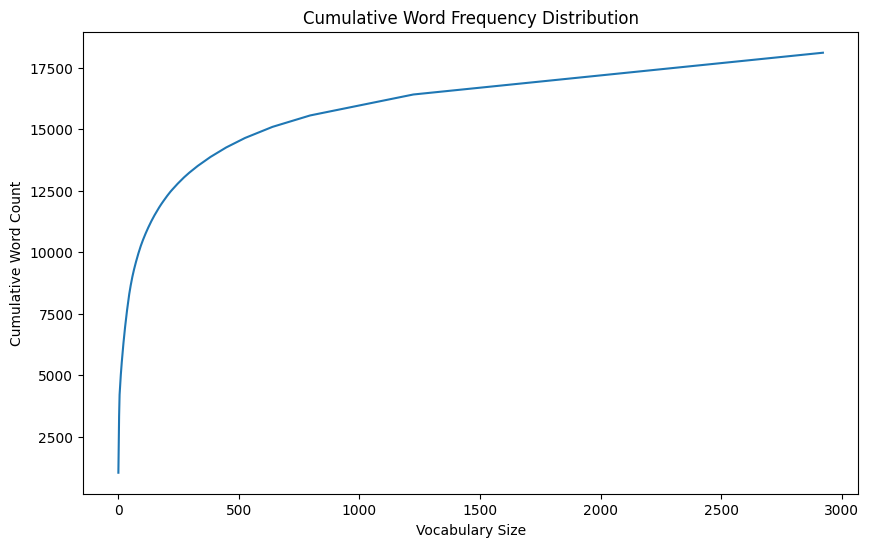

In [94]:
# plot distribusi frekuensi kumulatif kata dataset bagus
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_frequencies2) + 1), cumulative_frequencies2)
plt.xlabel('Vocabulary Size')
plt.ylabel('Cumulative Word Count')
plt.title('Cumulative Word Frequency Distribution')
plt.show()

- Distribusi kata dalam dataset ini juga cenderung mengikuti pola long tail, dengan sejumlah kecil kata yang sering muncul dan sebagian besar kata yang jarang muncul.
- Kata-kata umum di awal sering muncul dalam hampir setiap dokumen, sedangkan kata yang lebih jarang digunakan tersebar di seluruh dataset bagus_modeling

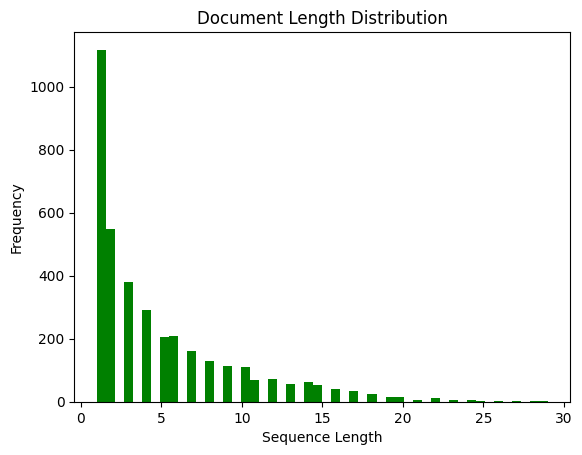

count    3737.000000
mean        4.846936
std         4.703649
min         1.000000
25%         1.000000
50%         3.000000
75%         7.000000
90%        12.000000
95%        15.000000
max        29.000000
Name: tokenized_reviews, dtype: float64


In [95]:
# hitung panjang urutan (jumlah kata) di setiap ulasan
sequence_lengths2 = bagus_modeling['tokenized_reviews'].apply(len)

# Plot sequence length distribution
plt.hist(sequence_lengths2, bins=50, color='green')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Document Length Distribution')
plt.show()

# Print descriptive stats
print(sequence_lengths2.describe(percentiles=[0.25, 0.5, 0.75, 0.90, 0.95]))

pada bagus_modeling ini:
- Sebagian besar dokumen memiliki panjang yang sangat pendek (1-5 kata) dengan jumlah dokumen tertinggi pada panjang urutan sekitar 1 kata.
- Setelah panjang urutan mencapai sekitar 5-10 kata, frekuensi dokumen mulai berkurang secara signifikan.
- Sebagian besar dokumen memiliki panjang antara 1 hingga 7 kata, sedangkan dokumen dengan panjang lebih dari 10 kata sangat jarang.
- Count (3737): Ada 3,737 dokumen dalam dataset.
- Mean (4.85): Rata-rata panjang dokumen adalah sekitar 4.85 kata.
- Std (4.70): Deviasi standar panjang dokumen adalah 4.70, menunjukkan adanya variasi yang cukup besar dalam panjang dokumen.
- Panjang dokumen terpanjang adalah 29 kata

In [96]:
top_n2 = 1250  # Adjust berdasarkan "Cumulative Word Frequency Distribution"
word_coverage2 = sum([freq for _, freq in sorted_word_counts2[:top_n2]]) / sum(word_frequencies2)
print(f"Word Coverage with top {top_n2} words: {word_coverage2:.2%}")

Word Coverage with top 1250 words: 90.77%


Dengan hanya menggunakan 1250 kata teratas, model sudah mencakup hampir 91% dari semua kemunculan kata dalam dataset, menunjukkan bahwa sebagian besar informasi dalam dataset dapat dijelaskan dengan hanya sebagian kecil kosakata.

In [97]:
dictionary2.filter_extremes(no_below=5, no_above=0.5, keep_n=1250)
print(f"Filtered dictionary size: {len(dictionary2)}")

Filtered dictionary size: 500


Filtered dictionary size: 500 menunjukkan bahwa setelah pemfilteran, hanya 500 kata yang memenuhi kriteria, lebih sedikit dari 1250 kata teratas yang diminta karena ada lebih banyak kata yang tidak memenuhi batasan frekuensi minimum dan maksimum.

Lalu, dilakukan konversi ulasan yang telah ditokenisasi menjadi Bag of Words menggunakan kamus dictionary2, yang siap digunakan untuk analisis atau model lebih lanjut.

In [98]:
# membuat bag of words
corpus2 = [dictionary2.doc2bow(review) for review in tokenized_reviews2]

In [99]:
# melatih model LDA untuk menemukan 3 topik utama dari corpus dengan parameter otomatis
lda_model_bagus = LdaModel(corpus=corpus2, 
                     id2word=dictionary2,
                     alpha='auto',
                     eta='auto',
                     iterations=100, 
                     num_topics=3, 
                     chunksize=500, 
                     passes=80, 
                     random_state=37)

- Menggunakan corpus2 (representasi Bag of Words) sebagai input untuk model LDA.
- Menyediakan kamus dictionary2 untuk menghubungkan ID kata dengan kata yang sebenarnya.
- alpha='auto': Secara otomatis mengatur distribusi topik pada dokumen.
- eta='auto': Secara otomatis mengatur distribusi kata pada topik.
- iterations=100: Melakukan 100 iterasi untuk melatih model.
- num_topics=3: Menentukan jumlah 3 topik yang ingin ditemukan dalam dataset.
- chunksize=500: Memproses 500 dokumen per batch untuk efisiensi.
- passes=80: Melakukan 80 kali pass untuk melatih model dengan corpus.

In [100]:
for i, topic in lda_model_bagus.show_topics(num_topics=3, num_words=30, formatted=False):
    print(f"Topic {i + 1}:")
    print(" ".join([word for word, _ in topic]))
    print()

Topic 1:
layan cepat bagus kirim ramah lambat kantor pakai waktu jasa antar langsung ekspedisi rumah nyaman kota sesuai moga tepat mudah ambil aman tempat muas kurir customer langgan lokasi paket bantu

Topic 2:
baik kerja bintang pesan nama online percaya utama pagi hari ongkir telepon pilih jual reguler mohon profesional rating daerah besok belanja pindah komplain siang kemarin buruk wilayah beli indonesia senin

Topic 3:
nan parkir respon orang luas staf nomor masuk bayar proses antri ruang cari gudang beda gratis sedia sayang cek enak mobil handphone fast admin whatsapp via motor sehat semangat jaga



- Topik 1 berkaitan dengan pengalaman pelanggan yang positif tentang layanan pengiriman yang cepat dan ramah. Banyak kata yang berfokus pada pengiriman yang baik, layanan pelanggan, dan keamanan. Kata-kata seperti "layan cepat", "kurir", "pakai jasa", dan "aman" menunjukkan pelanggan yang puas dengan layanan yang cepat dan aman.
- Topik 2 berfokus pada kualitas kerja dan kepercayaan pelanggan terhadap layanan. Banyak kata yang menunjukkan evaluasi baik atau buruk terkait layanan, seperti "baik kerja", "rating", dan "komplain".
- Topik 3 lebih berfokus pada masalah operasional dan layanan di kantor cabang, seperti parkir, respon staf, dan proses pengambilan barang. Kata-kata seperti "parkir", "proses", "staf", dan "admin" menunjukkan perhatian terhadap aspek layanan offline dan pengalaman pelanggan terkait proses fisik pengambilan atau pengiriman barang.

In [101]:
# evaluasi dengan hitung coherence score lda_model_bagus
coherence_model2 = CoherenceModel(model=lda_model_bagus, texts=bagus_modeling['tokenized_reviews'], dictionary=dictionary2, coherence='c_v')
coherence_score2 = coherence_model2.get_coherence()

In [102]:
# display coherence score untuk data dengan ulasan bagus
print(f"Coherence Score: {coherence_score2}")

Coherence Score: 0.44461283278991903


Skor 0.44 menunjukkan bahwa topik yang ditemukan oleh model LDA pada dataset ulasan bagus cukup koheren tapi masih bisa ditingkatkan. 

In [103]:
vis2 = gensimvis.prepare(lda_model_bagus, corpus2, dictionary2)
pyLDAvis.display(vis)

In [104]:
# assign label per topic
topic_labels_bagus = {
    0: "Pelayanan Bagus",
    1: "Kantor Cabang",
    2: "Respon Staff"
}

- 0: "Pelayanan Bagus": Topik 0 diberikan label "Pelayanan Bagus", yang mungkin berfokus pada pengalaman positif pelanggan terkait dengan layanan yang baik yang mereka terima.
- 1: "Kantor Cabang": Topik 1 diberikan label "Kantor Cabang", yang mungkin berhubungan dengan pengalaman pelanggan di kantor cabang atau lokasi fisik perusahaan.
- 2: "Respon Staff": Topik 2 diberikan label "Respon Staff", yang menunjukkan evaluasi pelanggan terhadap respon atau pelayanan staf perusahaan.

Lalu dilanjut dengan memberikan label deskriptif untuk setiap dokumen berdasarkan topik yang paling relevan (dengan probabilitas tertinggi) yang ditemukan oleh model LDA.

In [105]:
# Assign labels to documents
doc_topics = [max(lda_model_bagus.get_document_topics(doc), key=lambda x: x[1])[0] for doc in corpus2]
bagus_modeling['topic'] = [topic_labels_bagus[topic] for topic in doc_topics]

Kemudian, identifikasi distribusi topik dalam dataset, yaitu seberapa banyak dokumen yang dibagi ke dalam setiap topik yang dihasilkan oleh model LDA.

In [106]:
bagus_modeling['topic'].value_counts()

topic
Pelayanan Bagus    3711
Respon Staff         14
Kantor Cabang        12
Name: count, dtype: int64

- Pelayanan Bagus: 3,711 dokumen berfokus pada pengalaman positif terkait pelayanan.
- Respon Staff: 14 dokumen berkaitan dengan respon staf.
- Kantor Cabang: 12 dokumen terkait dengan pengalaman di kantor cabang.
> Pelayanan Bagus adalah topik yang paling dominan dalam dataset, sementara Respon Staff dan Kantor Cabang memiliki frekuensi yang sangat rendah.

In [107]:
# simpan bagus_modeling sebagai file csv untuk inference 
# bagus_modeling.to_csv("bagus_labeled_documents.csv", index=False)

# 11. Saving the models

## 11.1. Jelek Modeling

In [108]:
# # buruk_modeling
# lda_model.save('jelek_lda_model.model')

# print("LDA model saved as 'jelek_lda_model.model'")

In [109]:
# # Save the dictionary
# dictionary.save('jelek_lda_dictionary.dict')

# # Save the corpus
# with open('jelek_lda_corpus.pkl', 'wb') as f:
#     pickle.dump(corpus, f)

# print("Dictionary and corpus saved.")

## 11.2. Bagus Modeling

In [110]:
# # buruk_modeling
# lda_model_bagus.save('bagus_lda_model.model')

# print("LDA model saved as 'bagus_lda_model.model'")

In [111]:
# # Save the dictionary
# dictionary2.save('bagus_lda_dictionary.dict')

# # Save the corpus
# with open('bagus_lda_corpus.pkl', 'wb') as f:
#     pickle.dump(corpus2, f)

# print("Dictionary and corpus saved.")